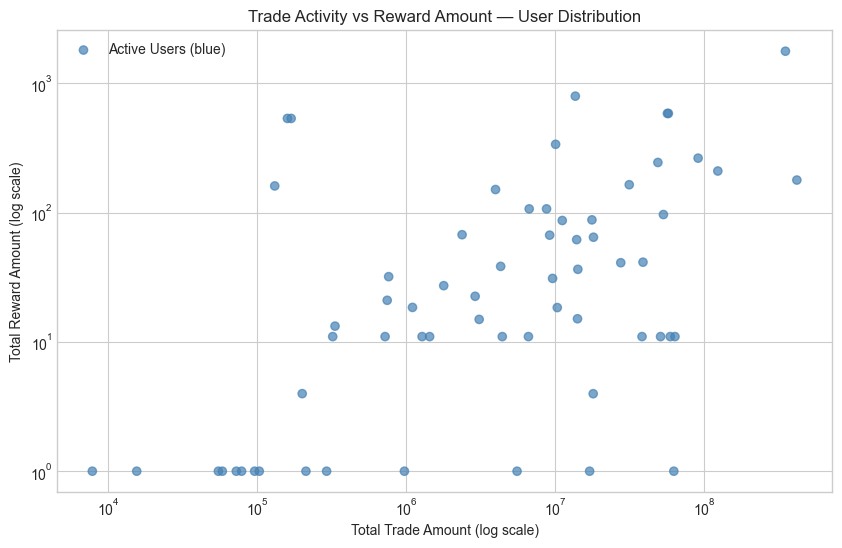

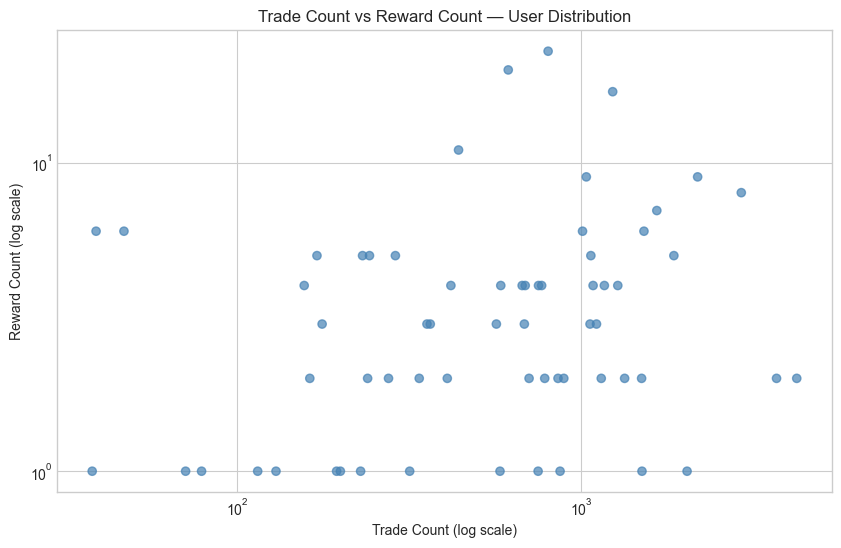

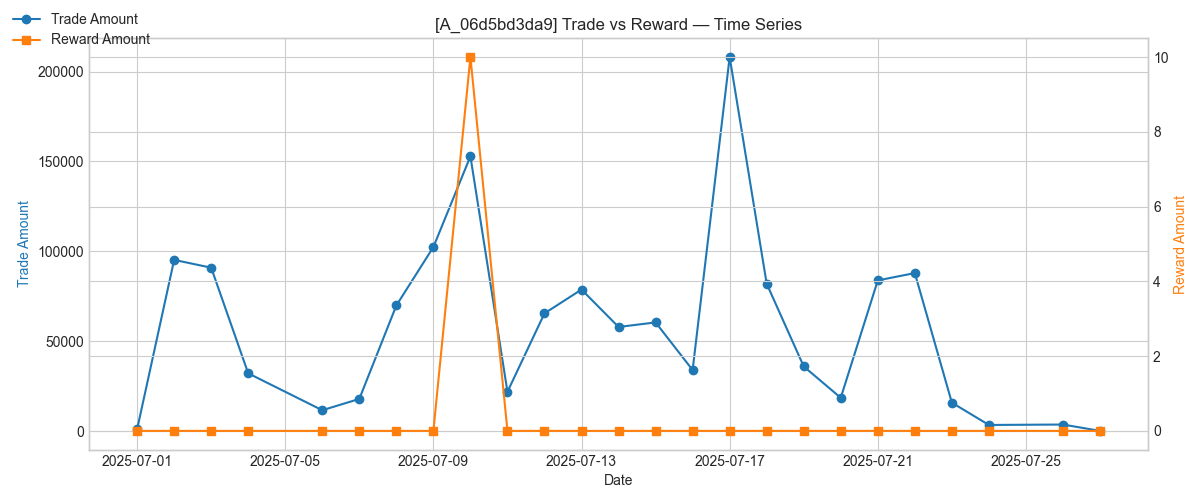

In [1]:
# ============================================
# 🔹 Step 0. Environment setup
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("seaborn-v0_8-whitegrid")

file_path = "problem_data_final.xlsx"

# ============================================
# 🔹 Step 1. Load data
# ============================================
reward = pd.read_excel(file_path, sheet_name="Reward")
funding = pd.read_excel(file_path, sheet_name="Funding")
trade = pd.read_excel(file_path, sheet_name="Trade")

# timestamp conversion
reward["ts"] = pd.to_datetime(reward["ts"])
funding["ts"] = pd.to_datetime(funding["ts"])
trade["ts"] = pd.to_datetime(trade["ts"])

# ============================================
# 🔹 Step 2. Trading activity indicators (Trade)
# ============================================
trade_summary = (
    trade.groupby("account_id")
    .agg(
        trade_count=("ts", "count"),
        total_trade_amount=("amount", "sum"),
        avg_trade_amount=("amount", "mean")
    )
    .reset_index()
)

# ============================================
# 🔹 Step 3. Reward activity indicators (Reward)
# ============================================
reward_summary = (
    reward.groupby("account_id")
    .agg(
        reward_count=("ts", "count"),
        total_reward_amount=("reward_amount", "sum"),
        avg_reward_amount=("reward_amount", "mean")
    )
    .reset_index()
)

# ============================================
# 🔹 Step 4. Merge (Trade + Reward)
# ============================================
user_summary = pd.merge(trade_summary, reward_summary, on="account_id", how="outer").fillna(0)

# inactive trader = no trading record
user_summary["is_inactive_trader"] = user_summary["trade_count"] == 0

# ============================================
# 🔹 Step 5. Visualization — overall distribution
# ============================================

# (1) Total trade amount vs total reward amount
plt.figure(figsize=(10,6))
plt.scatter(
    user_summary["total_trade_amount"] + 1,
    user_summary["total_reward_amount"] + 1,
    c=np.where(user_summary["is_inactive_trader"], "red", "steelblue"),
    alpha=0.7,
    label="Users"
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total Trade Amount (log scale)")
plt.ylabel("Total Reward Amount (log scale)")
plt.title("Trade Activity vs Reward Amount — User Distribution")
plt.legend(["Active Users (blue)", "Inactive / Reward-only Users (red)"])
plt.show()

# (2) Trade count vs reward count
plt.figure(figsize=(10,6))
plt.scatter(
    user_summary["trade_count"] + 1,
    user_summary["reward_count"] + 1,
    c=np.where(user_summary["is_inactive_trader"], "red", "steelblue"),
    alpha=0.7
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Trade Count (log scale)")
plt.ylabel("Reward Count (log scale)")
plt.title("Trade Count vs Reward Count — User Distribution")
plt.show()

# ============================================
# 🔹 Step 6. Time series analysis (per user)
# ============================================
# Aggregate daily trading and reward data
trade_daily = trade.groupby(["account_id", trade["ts"].dt.date]).agg(
    daily_trade_amount=("amount", "sum"),
    daily_trade_count=("ts", "count")
).reset_index()

reward_daily = reward.groupby(["account_id", reward["ts"].dt.date]).agg(
    daily_reward_amount=("reward_amount", "sum"),
    daily_reward_count=("ts", "count")
).reset_index()

# Merge by account_id and date
activity_daily = pd.merge(trade_daily, reward_daily, on=["account_id", "ts"], how="outer").fillna(0)

# Select one user for time series example
example_user = activity_daily["account_id"].unique()[0]
user_df = activity_daily[activity_daily["account_id"] == example_user]

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(user_df["ts"], user_df["daily_trade_amount"], color="C0", marker="o", label="Trade Amount")
ax2 = ax1.twinx()
ax2.plot(user_df["ts"], user_df["daily_reward_amount"], color="C1", marker="s", label="Reward Amount")

ax1.set_xlabel("Date")
ax1.set_ylabel("Trade Amount", color="C0")
ax2.set_ylabel("Reward Amount", color="C1")
plt.title(f"[{example_user}] Trade vs Reward — Time Series")
fig.legend(loc="upper left")
plt.tight_layout()
plt.show()


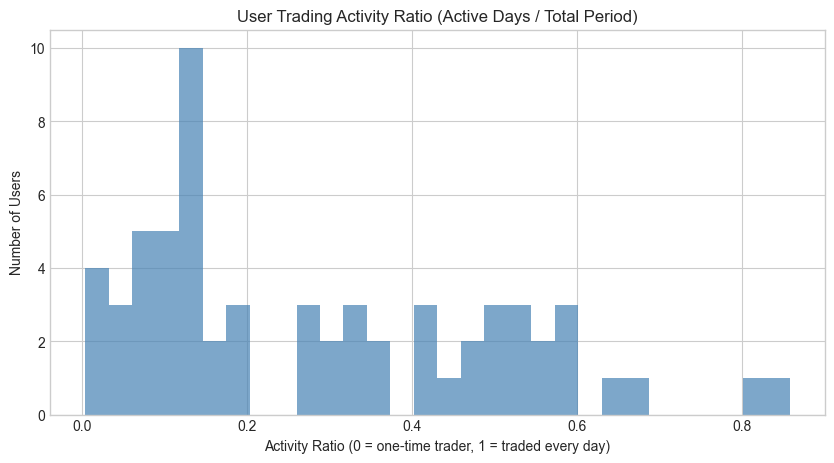

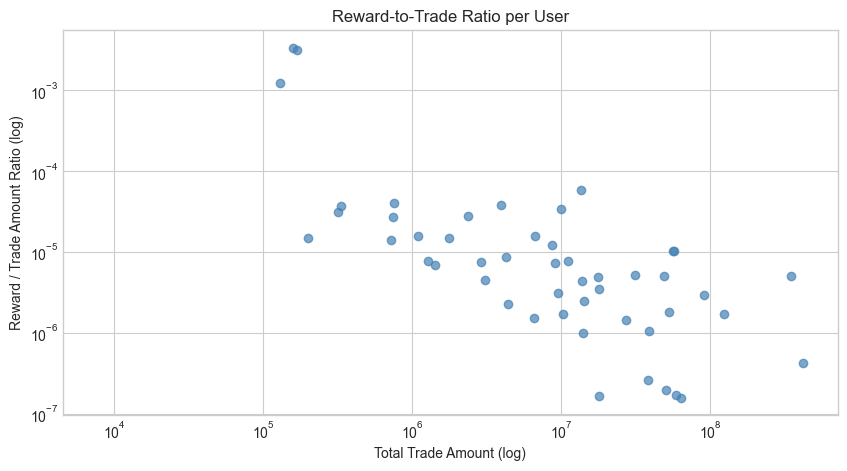

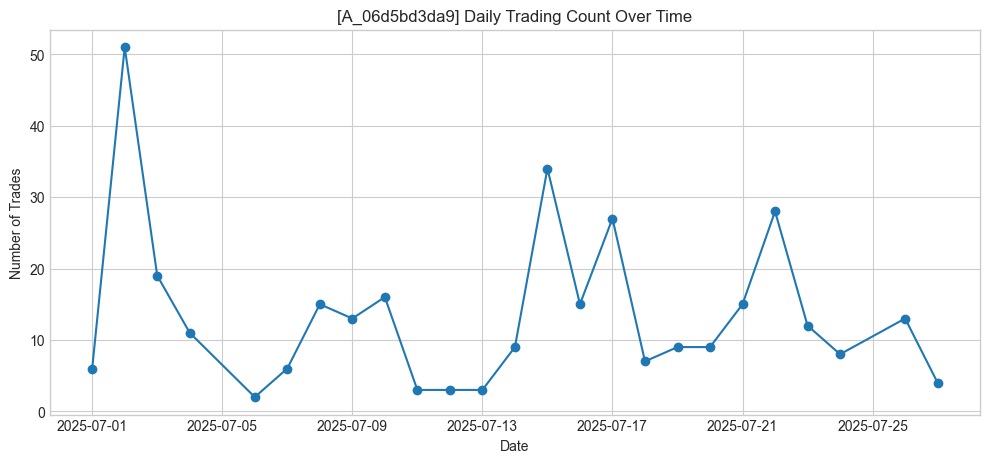

In [2]:
# ============================================
# 🔹 Step 0. Setup
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("seaborn-v0_8-whitegrid")

file_path = "problem_data_final.xlsx"

# ============================================
# 🔹 Step 1. Load
# ============================================
reward = pd.read_excel(file_path, sheet_name="Reward")
trade = pd.read_excel(file_path, sheet_name="Trade")

reward["ts"] = pd.to_datetime(reward["ts"])
trade["ts"] = pd.to_datetime(trade["ts"])

# ============================================
# 🔹 Step 2. 일별 거래 빈도 계산
# ============================================
trade_daily = (
    trade.groupby(["account_id", trade["ts"].dt.date])
    .agg(daily_trade_amount=("amount", "sum"), daily_trade_count=("ts", "count"))
    .reset_index()
)

# ============================================
# 🔹 Step 3. 유저별 거래 지속성 지표 계산
# ============================================
# 각 유저별 거래한 일수 / 전체 기간
total_days = (trade["ts"].max().date() - trade["ts"].min().date()).days + 1
user_trade_activity = (
    trade_daily.groupby("account_id")["ts"].nunique().reset_index(name="active_days")
)
user_trade_activity["activity_ratio"] = user_trade_activity["active_days"] / total_days

# ============================================
# 🔹 Step 4. 리워드 대비 거래 비율 계산
# ============================================
trade_summary = trade.groupby("account_id")["amount"].sum().reset_index(name="total_trade_amount")
reward_summary = reward.groupby("account_id")["reward_amount"].sum().reset_index(name="total_reward_amount")

user_reward_eff = pd.merge(trade_summary, reward_summary, on="account_id", how="outer").fillna(0)
user_reward_eff["reward_to_trade_ratio"] = user_reward_eff["total_reward_amount"] / (user_reward_eff["total_trade_amount"] + 1e-6)

# ============================================
# 🔹 Step 5. 병합 (활동성 + 리워드비율)
# ============================================
user_stats = pd.merge(user_trade_activity, user_reward_eff, on="account_id", how="left").fillna(0)

# ============================================
# 🔹 Step 6. 전체 분포 시각화
# ============================================

# (1) 유저별 거래 지속성 분포
plt.figure(figsize=(10,5))
plt.hist(user_stats["activity_ratio"], bins=30, color="steelblue", alpha=0.7)
plt.title("User Trading Activity Ratio (Active Days / Total Period)")
plt.xlabel("Activity Ratio (0 = one-time trader, 1 = traded every day)")
plt.ylabel("Number of Users")
plt.show()

# (2) 거래금액 대비 리워드 비율 분포
plt.figure(figsize=(10,5))
plt.scatter(
    user_stats["total_trade_amount"] + 1,
    user_stats["reward_to_trade_ratio"],
    alpha=0.7,
    c="steelblue"
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total Trade Amount (log)")
plt.ylabel("Reward / Trade Amount Ratio (log)")
plt.title("Reward-to-Trade Ratio per User")
plt.show()

# ============================================
# 🔹 Step 7. 개별 유저 시계열 보기 (선택적)
# ============================================
example_user = trade_daily["account_id"].unique()[0]
user_df = trade_daily[trade_daily["account_id"] == example_user]

plt.figure(figsize=(12,5))
plt.plot(user_df["ts"], user_df["daily_trade_count"], marker="o")
plt.title(f"[{example_user}] Daily Trading Count Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Trades")
plt.show()


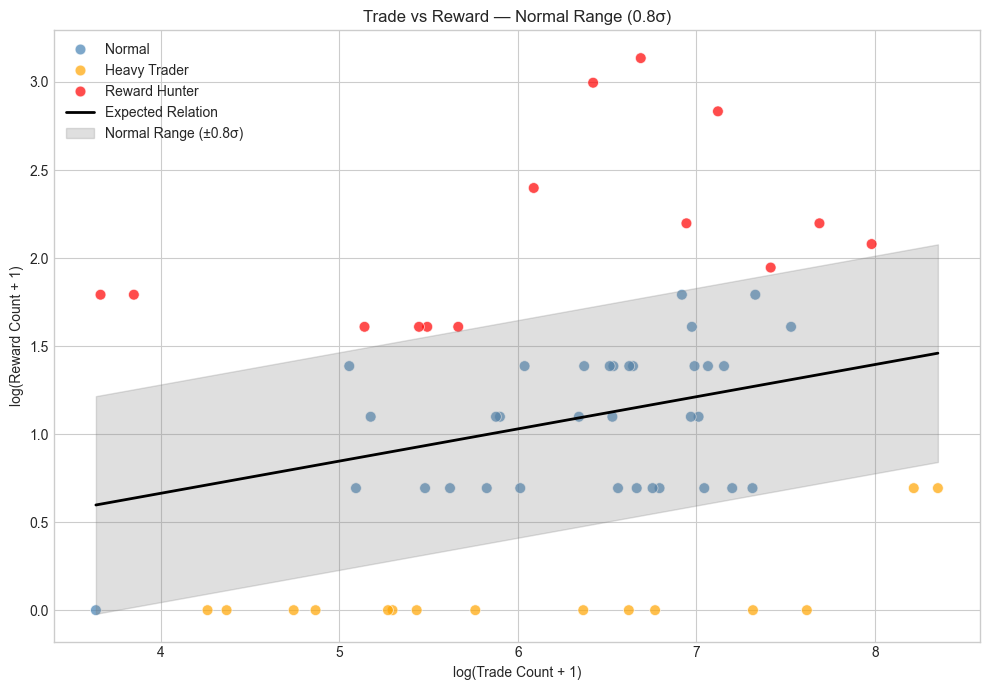


📊 User Group Statistics:
               trade_count              reward_count               residual  \
                      mean median count         mean median count      mean   
user_type                                                                     
Heavy Trader   1000.466667  317.0    15     0.133333    0.0    15 -0.952554   
Normal          765.735294  729.0    34     2.176471    2.0    34 -0.023763   
Reward Hunter   850.785714  527.0    14     8.714286    6.5    14  1.078304   

                               
                 median count  
user_type                      
Heavy Trader  -0.901147    15  
Normal         0.047014    34  
Reward Hunter  0.927000    14  

✅ Saved as user_trade_reward_labeled_0.8sigma.csv

🔥 Top Reward Hunter Suspicious Accounts:
      account_id  trade_count  reward_count  total_reward  suspicion_score  \
62  A_f96ede8d34          802          22.0    796.028294         1.980142   
10  A_2db64f326b          614          19.0    263.123582 

In [2]:
# ============================================
# 🔹 Step 0. Setup
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (10, 8)
plt.style.use("seaborn-v0_8-whitegrid")

file_path = "problem_data_final.xlsx"

# ============================================
# 🔹 Step 1. Load Data
# ============================================
reward = pd.read_excel(file_path, sheet_name="Reward")
trade = pd.read_excel(file_path, sheet_name="Trade")

reward["ts"] = pd.to_datetime(reward["ts"])
trade["ts"] = pd.to_datetime(trade["ts"])

# ============================================
# 🔹 Step 2. Aggregate by User (Trade & Reward count)
# ============================================
trade_summary = trade.groupby("account_id")["ts"].count().reset_index(name="trade_count")
reward_summary = reward.groupby("account_id")["ts"].count().reset_index(name="reward_count")

user_summary = pd.merge(trade_summary, reward_summary, on="account_id", how="outer").fillna(0)

# ============================================
# 🔹 Step 3. Log-transform for linear relation
# ============================================
user_summary["log_trade"] = np.log1p(user_summary["trade_count"])
user_summary["log_reward"] = np.log1p(user_summary["reward_count"])

# ============================================
# 🔹 Step 4. Fit regression model (Reward ≈ f(Trade))
# ============================================
X = user_summary["log_trade"].values.reshape(-1, 1)
y = user_summary["log_reward"].values

model = LinearRegression().fit(X, y)
pred = model.predict(X)
resid = y - pred

user_summary["residual"] = resid

# ============================================
# 🔹 Step 5. Define Normal Range (±0.8σ band)
# ============================================
sigma = np.std(resid)

upper_sigma = 0.8 * sigma
lower_sigma = -0.8 * sigma

user_summary["upper_bound"] = pred + upper_sigma
user_summary["lower_bound"] = pred + lower_sigma

# 라벨링
user_summary["user_type"] = "Normal"
user_summary.loc[user_summary["residual"] > upper_sigma, "user_type"] = "Reward Hunter"
user_summary.loc[user_summary["residual"] < lower_sigma, "user_type"] = "Heavy Trader"

# ============================================
# 🔹 Step 6. Visualization
# ============================================
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=user_summary,
    x="log_trade",
    y="log_reward",
    hue="user_type",
    palette={
        "Normal": "steelblue",
        "Reward Hunter": "red",
        "Heavy Trader": "orange",
    },
    alpha=0.7,
    s=60
)

# 회귀선
x_line = np.linspace(user_summary["log_trade"].min(), user_summary["log_trade"].max(), 200).reshape(-1, 1)
y_line = model.predict(x_line)

plt.plot(x_line, y_line, color="black", linewidth=2, label="Expected Relation")

# 정상 범위 밴드 (±0.8σ)
plt.fill_between(
    x_line.ravel(),
    y_line - 0.8 * sigma,
    y_line + 0.8 * sigma,
    color="gray",
    alpha=0.25,
    label="Normal Range (±0.8σ)"
)

plt.xlabel("log(Trade Count + 1)")
plt.ylabel("log(Reward Count + 1)")
plt.title("Trade vs Reward — Normal Range (0.8σ)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# ============================================
# 🔹 Step 7. Summary Statistics
# ============================================
group_stats = (
    user_summary.groupby("user_type")[["trade_count", "reward_count", "residual"]]
    .agg(["mean", "median", "count"])
)
print("\n📊 User Group Statistics:")
print(group_stats)

# ============================================
# 🔹 Step 8. Export labeled result
# ============================================
user_summary.to_csv("user_trade_reward_labeled_0.8sigma.csv", index=False)
print("\n✅ Saved as user_trade_reward_labeled_0.8sigma.csv")

# ============================================
# 🔹 Step 9. Attach IP info (most frequent IP)
# ============================================
ip_df = pd.read_excel(file_path, sheet_name="IP")

account_main_ip = (
    ip_df.groupby("account_id")["ip"]
         .agg(lambda x: x.value_counts().index[0])
         .reset_index()
         .rename(columns={"ip": "main_ip"})
)

# ============================================
# 🔹 Step 10. Compute total reward per account
# ============================================
total_reward_df = (
    reward.groupby("account_id")["reward_amount"]
          .sum()
          .reset_index()
          .rename(columns={"reward_amount": "total_reward"})
)

user_summary = user_summary.merge(account_main_ip, on="account_id", how="left")
user_summary = user_summary.merge(total_reward_df, on="account_id", how="left")

# ============================================
# 🔹 Step 11. Extract Reward Hunters (sorted)
# ============================================
reward_hunters = user_summary[user_summary["user_type"] == "Reward Hunter"].copy()

reward_hunters["suspicion_score"] = reward_hunters["residual"]

reward_hunters_sorted = reward_hunters.sort_values("suspicion_score", ascending=False)

print("\n🔥 Top Reward Hunter Suspicious Accounts:")
print(reward_hunters_sorted[[
    "account_id", 
    "trade_count", 
    "reward_count", 
    "total_reward",     # 이거 추가됨!!
    "suspicion_score", 
    "main_ip"
]].head(20))

# Save
reward_hunters_sorted.to_csv("reward_hunter_ranked_with_ip_reward.csv", index=False)
print("\n📁 Saved as reward_hunter_ranked_with_ip_reward.csv")

